In [11]:
import torch
from torch import nn
import torch.optim as optim

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [13]:
# Загрузка и подготовка данных CIFAR-10
def get_cifar10_data(batch_size=64):  # Уменьшил batch_size для скорости
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)  # workers=0 для скорости

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

    return trainloader, testloader

In [14]:
def build_alexnet(num_classes=10):
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net = nn.Sequential(
        # Input: 32x32x3 (CIFAR-10)

        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x16x64

        # Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 8x8x128

        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),  # Output: 8x8x256

        # Layer 4
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),  # Output: 8x8x256

        # Layer 5
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 4x4x128

        nn.Flatten(),

        # Fully Connected Layers
        nn.Dropout(0.5),
        nn.Linear(128 * 4 * 4, 512),
        nn.ReLU(inplace=True),

        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),

        nn.Linear(256, num_classes)
    )

    net.apply(init_weights)
    return net

In [15]:
def train_alexnet(net, train_loader, device, num_epochs=20, learning_rate=0.01):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    loss_function = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            net.train()
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total

                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.4f, Acc: %.2f" %
                                   (epoch+1, batch_num+1, running_loss/(batch_num+1), batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            scheduler.step()

            # Print the evaluation metric and reset it for the next epoch
            epoch_acc = correct/total
            acc_history.append(epoch_acc)
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, '
                  f'Train Acc: {epoch_acc:.2%}')

        pbar.close()

    return acc_history

In [16]:
# Функция оценки
def evaluate_acc(net, test_loader, device):
    net.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_num, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct/total
    return acc

In [17]:
# Функция визуализации
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()

Training samples: 50000
Test samples: 10000
Batch size: 64
Epochs: 20
AlexNet architecture:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=2048, out_features=512, bias=True)
  (16

Epoch: 1, Batch: 782, Loss: 1.7045, Acc: 0.44:   5%|▍         | 781/15640 [03:31<1:00:40,  4.08it/s]

Epoch 1/20, Loss: 1.7045, Train Acc: 35.93%


Epoch: 2, Batch: 782, Loss: 1.2240, Acc: 0.62:  10%|▉         | 1563/15640 [06:56<1:05:38,  3.57it/s]

Epoch 2/20, Loss: 1.2240, Train Acc: 55.27%


Epoch: 3, Batch: 782, Loss: 0.9917, Acc: 0.62:  15%|█▍        | 2345/15640 [10:28<57:25,  3.86it/s]  

Epoch 3/20, Loss: 0.9917, Train Acc: 64.48%


Epoch: 4, Batch: 782, Loss: 0.8479, Acc: 0.75:  20%|█▉        | 3127/15640 [13:56<56:29,  3.69it/s]  

Epoch 4/20, Loss: 0.8479, Train Acc: 70.20%


Epoch: 5, Batch: 782, Loss: 0.7446, Acc: 0.75:  25%|██▍       | 3909/15640 [17:29<48:10,  4.06it/s]  

Epoch 5/20, Loss: 0.7446, Train Acc: 74.08%


Epoch: 6, Batch: 782, Loss: 0.6635, Acc: 0.75:  30%|██▉       | 4691/15640 [20:43<45:32,  4.01it/s]  

Epoch 6/20, Loss: 0.6635, Train Acc: 76.97%


Epoch: 7, Batch: 782, Loss: 0.5938, Acc: 0.75:  35%|███▍      | 5473/15640 [23:58<41:07,  4.12it/s]  

Epoch 7/20, Loss: 0.5938, Train Acc: 79.51%


Epoch: 8, Batch: 782, Loss: 0.5307, Acc: 0.88:  40%|███▉      | 6255/15640 [27:14<37:20,  4.19it/s]  

Epoch 8/20, Loss: 0.5307, Train Acc: 81.67%


Epoch: 9, Batch: 782, Loss: 0.4773, Acc: 0.81:  45%|████▍     | 7037/15640 [30:20<33:47,  4.24it/s]

Epoch 9/20, Loss: 0.4773, Train Acc: 83.47%


Epoch: 10, Batch: 782, Loss: 0.4351, Acc: 1.00:  50%|████▉     | 7819/15640 [33:27<30:48,  4.23it/s]

Epoch 10/20, Loss: 0.4351, Train Acc: 85.09%


Epoch: 11, Batch: 782, Loss: 0.2548, Acc: 1.00:  55%|█████▍    | 8601/15640 [36:34<27:42,  4.23it/s]

Epoch 11/20, Loss: 0.2548, Train Acc: 91.38%


Epoch: 12, Batch: 782, Loss: 0.2125, Acc: 0.88:  60%|██████    | 9384/15640 [39:59<24:00,  4.34it/s]

Epoch 12/20, Loss: 0.2125, Train Acc: 92.87%


Epoch: 13, Batch: 782, Loss: 0.1883, Acc: 1.00:  65%|██████▍   | 10165/15640 [43:47<24:16,  3.76it/s]

Epoch 13/20, Loss: 0.1883, Train Acc: 93.64%


Epoch: 14, Batch: 782, Loss: 0.1682, Acc: 0.81:  70%|██████▉   | 10947/15640 [47:04<19:45,  3.96it/s]

Epoch 14/20, Loss: 0.1682, Train Acc: 94.41%


Epoch: 15, Batch: 782, Loss: 0.1529, Acc: 0.94:  75%|███████▍  | 11729/15640 [50:21<16:13,  4.02it/s]

Epoch 15/20, Loss: 0.1529, Train Acc: 94.93%


Epoch: 16, Batch: 782, Loss: 0.1373, Acc: 0.94:  80%|███████▉  | 12511/15640 [53:38<13:01,  4.00it/s]

Epoch 16/20, Loss: 0.1373, Train Acc: 95.38%


Epoch: 17, Batch: 782, Loss: 0.1231, Acc: 0.94:  85%|████████▍ | 13293/15640 [56:55<09:41,  4.03it/s]

Epoch 17/20, Loss: 0.1231, Train Acc: 95.87%


Epoch: 18, Batch: 782, Loss: 0.1136, Acc: 0.94:  90%|████████▉ | 14075/15640 [1:00:12<06:30,  4.01it/s]

Epoch 18/20, Loss: 0.1136, Train Acc: 96.20%


Epoch: 19, Batch: 782, Loss: 0.1028, Acc: 1.00:  95%|█████████▍| 14857/15640 [1:03:29<03:12,  4.06it/s]

Epoch 19/20, Loss: 0.1028, Train Acc: 96.57%


Epoch: 20, Batch: 782, Loss: 0.0919, Acc: 1.00: 100%|██████████| 15640/15640 [1:06:48<00:00,  3.90it/s]


Epoch 20/20, Loss: 0.0919, Train Acc: 97.01%

Test Accuracy (AlexNet): 84.43%


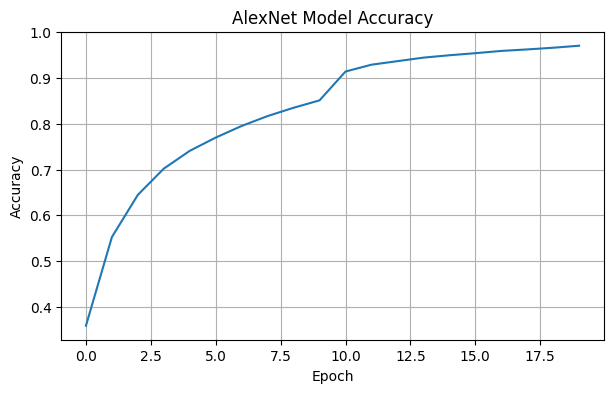

In [18]:
batch_size = 64
epochs = 20
lr = 0.01

train_dataloader, test_dataloader = get_cifar10_data(batch_size)

print(f"Training samples: {len(train_dataloader.dataset)}")
print(f"Test samples: {len(test_dataloader.dataset)}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")

# Создание модели
alexnet = build_alexnet(num_classes=10)
alexnet = alexnet.to(device)
print("AlexNet architecture:")
print(alexnet)

# Обучение 
hist_alexnet = train_alexnet(alexnet, train_dataloader, device, epochs, lr)

# Оценка
alexnet_acc = evaluate_acc(alexnet, test_dataloader, device)
print(f'\nTest Accuracy (AlexNet): {alexnet_acc:.2%}')

# Визуализация
print_history(hist_alexnet, "AlexNet Model Accuracy")